In [42]:
import os
import torch
from torch import nn
from torch.autograd import Variable
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transfBhattacharyyaorms
import utils
from discriminators import define_Dis
from generators import define_Gen
import numpy as np

In [43]:
crop_height = 128
crop_width = 128
dataset_dir = './datasets/sketch2waterpokemon'
checkpoint_dir = './checkpoints'
checkpoint_name = 'latest'
results_dir = './results'
batch_size = 1
ngf = 64
norm = 'instance'
no_dropout = False
gpu_ids = [0]

In [44]:
transform = transforms.Compose(
    [transforms.Resize((crop_height,crop_width)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

dataset_dirs = utils.get_testdata_link(dataset_dir)

a_test_data = dsets.ImageFolder(dataset_dirs['testA'], transform=transform)
b_test_data = dsets.ImageFolder(dataset_dirs['testB'], transform=transform)


a_test_loader = torch.utils.data.DataLoader(a_test_data, batch_size=batch_size, shuffle=False, num_workers=4) # set shuffle to false for testing
b_test_loader = torch.utils.data.DataLoader(b_test_data, batch_size=batch_size, shuffle=False, num_workers=4)

Gab = define_Gen(input_nc=3, output_nc=3, ngf=ngf, netG='resnet_9blocks', norm=norm, 
                                                use_dropout= not no_dropout, gpu_ids=gpu_ids)
Gba = define_Gen(input_nc=3, output_nc=3, ngf=ngf, netG='resnet_9blocks', norm=norm, 
                                                use_dropout= not no_dropout, gpu_ids=gpu_ids)

utils.print_networks([Gab,Gba], ['Gab','Gba'])

Network initialized with weights sampled from N(0,0.02).
Network initialized with weights sampled from N(0,0.02).
------------Number of Parameters---------------
[Network Gab] Total number of parameters : 11.378 M
[Network Gba] Total number of parameters : 11.378 M
-----------------------------------------------


In [50]:
try:
    ckpt = utils.load_checkpoint('%s/%s.ckpt' % (checkpoint_dir, checkpoint_name))
    Gab.load_state_dict(ckpt['Gab'])
    Gba.load_state_dict(ckpt['Gba'])
except:
    print(' [*] No checkpoint!')

 [*] Loading checkpoint from ./checkpoints/latest.ckpt succeed!


In [46]:
a_train_loader = torch.utils.data.DataLoader(dsets.ImageFolder(utils.get_traindata_link(dataset_dir)['trainA'], transform=transform), 
                                                batch_size=batch_size, shuffle=False, num_workers=4)
b_train_loader = torch.utils.data.DataLoader(dsets.ImageFolder(utils.get_traindata_link(dataset_dir)['trainB'], transform=transform), 
                                                batch_size=batch_size, shuffle=False, num_workers=4)

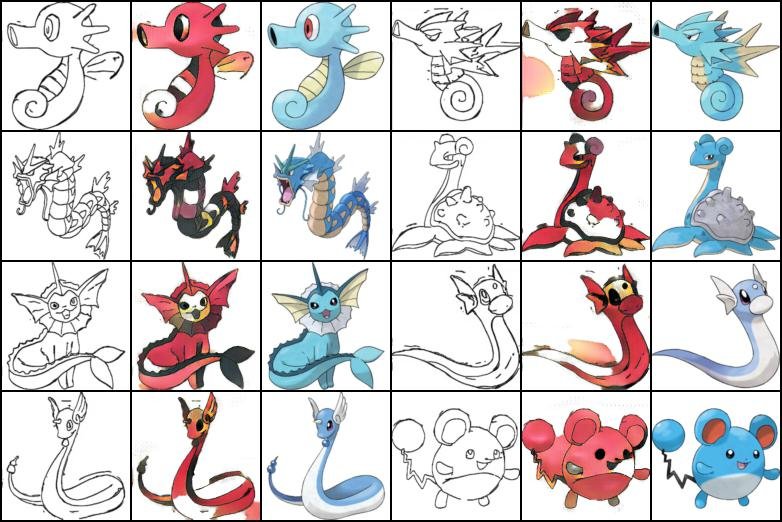

In [51]:
from PIL import Image
import matplotlib.pyplot as plt

def gen(idx=0):
    itera = iter(a_test_loader)
    iterb = iter(b_test_loader)
    for i in range(idx+1):
        a = itera.next()
        b = iterb.next()
    a_real_test = Variable(a[0], requires_grad=True)
    b_real_test = Variable(b[0], requires_grad=True)
    a_real_test, b_real_test = utils.cuda([a_real_test, b_real_test])
            

    Gab.eval()
    Gba.eval()

    with torch.no_grad():
        a_fake_test = Gab(b_real_test)
        b_fake_test = Gba(a_real_test)
        a_recon_test = Gab(b_fake_test)
        b_recon_test = Gba(a_fake_test)

        pic = (torch.cat([a_real_test, b_fake_test], dim=0).data + 1) / 2.0

        if not os.path.isdir(results_dir):
            os.makedirs(results_dir)

        torchvision.utils.save_image(pic, results_dir+'/sample_%d.jpg' % idx, nrow=3)

def print_test(len):
    itera = iter(a_test_loader)
    iterb = iter(b_test_loader)
    res = []
    for i in range(len):
        a = itera.next()
        b = iterb.next()
        a_real_test = Variable(a[0], requires_grad=True)
        b_real_test = Variable(b[0], requires_grad=True)
        a_real_test, b_real_test = utils.cuda([a_real_test, b_real_test])
        Gab.eval()
        Gba.eval()

        with torch.no_grad():
            a_fake_test = Gab(b_real_test)
            b_fake_test = Gba(a_real_test)
            a_recon_test = Gab(b_fake_test)
            b_recon_test = Gba(a_fake_test)
            bft = [b_fake_test]
            bft = (torch.cat(bft, dim=0).data + 1) / 2.0
            res.extend([a_real_test, b_fake_test, b_real_test])
            torchvision.utils.save_image(bft, results_dir + '/output_%d.jpg' % i)
#             npimg = b_fake_test.cpu().numpy().reshape(128, 128, 3)
#             plt.imshow(np.transpose(npimg), interpolation='nearest')

    pic = (torch.cat(res, dim=0).data + 1) / 2.0

    if not os.path.isdir(results_dir):
        os.makedirs(results_dir)

    torchvision.utils.save_image(pic, results_dir+'/result_%d.jpg' % ckpt['epoch'], nrow=6)

# idx = 16
# gen(idx)
# from IPython.display import Image
# Image(filename=results_dir+'/sample_%d.jpg' % idx) 

print_test(8)

from IPython.display import Image
Image(filename=results_dir+'/result_%d.jpg' % ckpt['epoch']) 

In [59]:
import cv2

def computeMetricsHSV(imga, imgb, isPrint=False):
    hsv_base = cv2.cvtColor(imga, cv2.COLOR_BGR2HSV)
    hsv_test1 = cv2.cvtColor(imgb, cv2.COLOR_BGR2HSV)
    h_bins = 50
    s_bins = 60
    v_bins = 60
    histSize = [h_bins, s_bins, v_bins]
    # hue varies from 0 to 179, saturation from 0 to 255, value from 0 to 255
    h_ranges = [0, 180]
    s_ranges = [0, 256]
    v_ranges = [0, 256]
    ranges = h_ranges + s_ranges + v_ranges# concat lists
    # Use 0,1,2nd channels
    channels = [0, 1, 2]
    hist_base = cv2.calcHist([hsv_base], channels, None, histSize, ranges, accumulate=False)
    cv2.normalize(hist_base, hist_base, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    hist_test1 = cv2.calcHist([hsv_test1], channels, None, histSize, ranges, accumulate=False)
    cv2.normalize(hist_test1, hist_test1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    # compare_method = {0: 'correlation', 1: 'chi-square', 2: 'intersection', 3: 'Bhattacharyya'}
    corr = cv2.compareHist(hist_base, hist_test1, 0)
    chisq = cv2.compareHist(hist_base, hist_test1, 1)
    intersectn = cv2.compareHist(hist_base, hist_test1, 2)
    bhat = cv2.compareHist(hist_base, hist_test1, 3)
    
    if isPrint:
        print('HistCompare_correlation: ', corr)
        print('HistCompare_chi_square: ', chisq)
        print('HistCompare_intersction: ', intersectn)
        print('HistCompare_bhat: ', bhat)
    
    return corr, chisq, intersectn, bhat

def computeMetrics(imga, imgb, isPrint=False):
    hsv_base = imga
    hsv_test1 = imgb
    h_bins = 50
    s_bins = 60
    v_bins = 60
    histSize = [h_bins, s_bins, v_bins]
    # hue varies from 0 to 179, saturation from 0 to 255, value from 0 to 255
    h_ranges = [0, 256]
    s_ranges = [0, 256]
    v_ranges = [0, 256]
    ranges = h_ranges + s_ranges + v_ranges# concat lists
    # Use 0,1,2nd channels
    channels = [0, 1, 2]
    hist_base = cv2.calcHist([hsv_base], channels, None, histSize, ranges, accumulate=False)
    cv2.normalize(hist_base, hist_base, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    hist_test1 = cv2.calcHist([hsv_test1], channels, None, histSize, ranges, accumulate=False)
    cv2.normalize(hist_test1, hist_test1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    # compare_method = {0: 'correlation', 1: 'chi-square', 2: 'intersection', 3: 'Bhattacharyya'}
    corr = cv2.compareHist(hist_base, hist_test1, 0)
    chisq = cv2.compareHist(hist_base, hist_test1, 1)
    intersectn = cv2.compareHist(hist_base, hist_test1, 2)
    bhat = cv2.compareHist(hist_base, hist_test1, 3)
    
    if isPrint:
        print('HistCompare_correlation: ', corr)
        print('HistCompare_chi_square: ', chisq)
        print('HistCompare_intersction: ', intersectn)
        print('HistCompare_bhat: ', bhat)
    
    return corr, chisq, intersectn, bhat

In [68]:
baseline_corr, baseline_chisq, baseline_inter, baseline_bhat = [],[],[],[]
improved_corr, improved_chisq, improved_inter, improved_bhat = [],[],[],[]
for i in range(8):
    truth = cv2.imread(results_dir + '/metrics_comparison/water_truth/output_%d.jpg' % i)
    baseline = cv2.imread(results_dir + '/metrics_comparison/water_baseline/output_%d.jpg' % i)
    improved = cv2.imread(results_dir + '/metrics_comparison/water_ours/output_%d.jpg' % i)
    a,b,c,d = computeMetricsHSV(baseline, truth)
    baseline_corr.append(a)
    baseline_chisq.append(b)
    baseline_inter.append(c)
    baseline_bhat.append(d)
    a,b,c,d = computeMetricsHSV(improved, truth)
    improved_corr.append(a)
    improved_chisq.append(b)
    improved_inter.append(c)
    improved_bhat.append(d)
print("chi squared (smaller)")
print("baseline: ", np.mean(baseline_chisq), np.std(baseline_chisq))
print("improved: ", np.mean(improved_chisq), np.std(improved_chisq))
print("intersection (larger)")
print("baseline: ", np.mean(baseline_inter), np.std(baseline_inter))
print("improved: ", np.mean(improved_inter), np.std(improved_inter))
print("bhat (smaller)")
print("baseline: ", np.mean(baseline_bhat), np.std(baseline_bhat))
print("improved: ", np.mean(improved_bhat), np.std(improved_bhat))

chi squared (smaller)
baseline:  2.880507752587195 1.8092273386451918
improved:  4.073060507422588 1.652890500933628
intersection (larger)
baseline:  1.108153558150434 0.017088739056076253
improved:  1.1567214085528121 0.030777684186923192
bhat (smaller)
baseline:  0.6692828576323104 0.05518103758277951
improved:  0.649224437940007 0.051872437849332584
